In [14]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("../Intro_ML/Data/train.csv", index_col="Id")

In [3]:
data.dropna(subset=['SalePrice'], axis=0)
y = data.SalePrice
X_full = data.drop(['SalePrice'], axis=1)

In [4]:
y.isnull().any()

False

In [6]:
categorical_cols = [cname for cname in X_full.columns
                   if X_full[cname].dtype == 'object' and
                   X_full[cname].nunique()<10]
numerical_cols = [cname for cname in X_full.columns
                 if X_full[cname].dtype in ['int64', 'float64']]
my_cols = categorical_cols + numerical_cols

In [7]:
X = X_full[my_cols].copy()
X.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,548,0,61,0,0,0,0,0,2,2008
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,...,460,298,0,0,0,0,0,0,5,2007
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,608,0,42,0,0,0,0,0,9,2008
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,642,0,35,272,0,0,0,0,2,2006
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,Norm,Norm,...,836,192,84,0,0,0,0,0,12,2008


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

In [33]:
numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [34]:
from xgboost import XGBRegressor

In [80]:
def get_score(n_est, rate):
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=n_est, learning_rate=rate, n_jobs=3))
    ])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                                 cv=5,
                                 scoring='neg_mean_absolute_error')
    return scores.mean()

In [81]:
estimator_list = [i for i in range(100, 1010, 100)]
rate_list = np.linspace(start=0.05, stop=0.5, endpoint=True, num=10)
print(estimator_list)
print(rate_list)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [82]:
#help(np.linspace)

In [83]:
a1 = pd.DataFrame(columns = ['num_estimator', 'learning_rate', 'MAE'])

#a1 = pd.concat([a1,pd.DataFrame([100,0.05,20])], ignore_index=True)
a1

,num_estimator,learning_rate,MAE


In [84]:
proposed_rate = rate_list[0]
results = {i:get_score(i,proposed_rate) for i in estimator_list}
results

[15:03:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

{100: 17235.209760273974,
 200: 16231.611649186641,
 300: 16007.782381742294,
 400: 15971.287481271405,
 500: 15962.438559503425,
 600: 15942.246230201199,
 700: 15950.102766481165,
 800: 15931.848503050085,
 900: 15918.61569456336,
 1000: 15953.318487799657}

In [85]:
def get_best_para(my_result):
    min_val = min(my_result.values())
    which_est = [k for k,v in my_result.items() if v==min_val]
    return which_est

In [88]:
print(get_best_para(results))
best_para_list = {'n_est':get_best_para(results)[0], 'rate':proposed_rate}
best_para_list

[900]


{'n_est': 900, 'rate': 0.05}

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

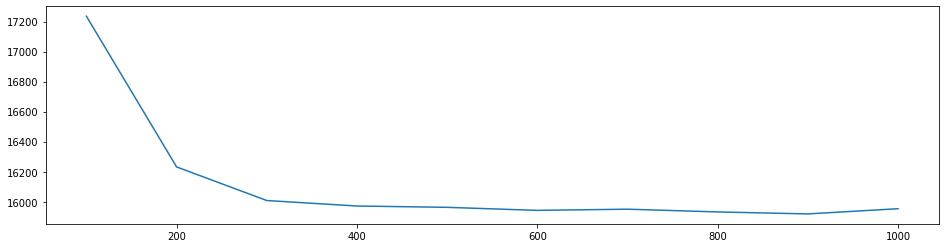

In [90]:
plt.figure(figsize=(16,4))
plt.plot(list(results.keys()), list(results.values()))

In [91]:
results.values()

dict_values([17235.209760273974, 16231.611649186641, 16007.782381742294, 15971.287481271405, 15962.438559503425, 15942.246230201199, 15950.102766481165, 15931.848503050085, 15918.61569456336, 15953.318487799657])

In [92]:
X_test_full = pd.read_csv("../Intro_ML/Data/test.csv", index_col="Id")
X_test = X_test_full[my_cols].copy()

In [93]:
def run_test(final_parm_list):
    n_est = final_parm_list['n_est']
    rate = final_parm_list['rate']
    
    the_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=n_est, learning_rate=rate, n_jobs=2))
    ])
    
    the_pipeline.fit(X, y)
    test_pred = the_pipeline.predict(X_test)
    return test_pred

In [94]:
test_pred = run_test(best_para_list)

[15:07:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [96]:
test_pred.shape
test_pred[0:5]

array([120367.51, 167079.78, 177609.9 , 192609.36, 181065.73],
      dtype=float32)

In [97]:
output = pd.DataFrame({'Id':X_test.index,
                      'SalePrice':test_pred})

In [98]:
output.head()

,Id,SalePrice
0,1461,120367.507812
1,1462,167079.781250
2,1463,177609.906250
3,1464,192609.359375
4,1465,181065.734375


In [99]:
output.to_csv('submission.csv', index=False)